# Fake news detection

We are going to attempt to label articles as either being real or fake.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from IPython.display import display, Markdown
import pandas as pd

def head(df: pd.DataFrame, n_rows:int=1) -> None:
    """
    Pretty-print the head of a Pandas table in a Jupyter notebook and show its dimensions.
    
    credit: https://gist.github.com/dmyersturnbull/035876942070ced4c565e4e96161be3e
    """
    display(Markdown("**Whole table (below):** {} rows × {} columns".format(len(df), len(df.columns))))
    display(df.head(n_rows))

[nltk_data] Downloading package punkt to /home/evan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/evan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Vectorization

As data we are going to use the text of each article, but first we need to convert it to a form appropriate for our models to train and predict on.. Vectors!
We are going to use tfidf vectors (Term frequency, Inverted Document Frequency).
Before vectorizing we are also going to remove stopwords from the text.

Also note that we are splitting our data into train(80%) and test(20%) sets.

In [18]:
# import boilerplate
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from string import punctuation

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

print("Loading from file..", end="")
# load data from file
df = pd.read_csv("train.csv")#, nrows = 10_000)

# drop data that does not have the required columns
df = df.dropna(subset=['author', 'title'])

print(".")
print("done")

# show data
head(df, n_rows=10)

# vectorize title and author
vectorizer = ColumnTransformer(
        [
            ('author_tfidf', TfidfVectorizer(use_idf=True, stop_words = stopwords.words("english")), 'author'),
            ('title_tfidf', TfidfVectorizer(use_idf=True, stop_words = stopwords.words("english")), 'title'),
            # ('text_tfidf', TfidfVectorizer(use_idf=True, stop_words = stopwords.words("english")), 'text')

        ],
        remainder='drop', verbose_feature_names_out=False)

# vectorizer = TfidfVectorizer(use_idf=True, stop_words = stopwords.words("english"))

print("Vectorizing..", end="")
tfidf = vectorizer.fit_transform(df)
print(".")

# split data into test and train tests
x_train, x_test, y_train, y_test = train_test_split(tfidf, df["label"], test_size=0.2, shuffle=True)

print("done")

display(Markdown("**Our column transformer**: it concists of multiple TdidfVectorizers"))
vectorizer

Loading from file...
done


**Whole table (below):** 18285 rows × 5 columns

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0
10,10,Obama’s Organizing for Action Partners with So...,Aaron Klein,"Organizing for Action, the activist group that...",0
11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0


Vectorizing...
done


**Our column transformer**: it concists of multiple TdidfVectorizers

ColumnTransformer(transformers=[('author_tfidf',
                                 TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                             'myself', 'we',
                                                             'our', 'ours',
                                                             'ourselves', 'you',
                                                             "you're", "you've",
                                                             "you'll", "you'd",
                                                             'your', 'yours',
                                                             'yourself',
                                                             'yourselves', 'he',
                                                             'him', 'his',
                                                             'himself', 'she',
                                                             "she's", 'her',
                                                             'hers', 'herself',
                                                             'it', "it's",
                                                             'its', 'itself', ...]),
                                 'author'),
                                ('title_tfidf',
                                 TfidfVectorizer(stop_words=['i', 'me', 'my',
                                                             'myself', 'we',
                                                             'our', 'ours',
                                                             'ourselves', 'you',
                                                             "you're", "you've",
                                                             "you'll", "you'd",
                                                             'your', 'yours',
                                                             'yourself',
                                                             'yourselves', 'he',
                                                             'him', 'his',
                                                             'himself', 'she',
                                                             "she's", 'her',
                                                             'hers', 'herself',
                                                             'it', "it's",
                                                             'its', 'itself', ...]),
                                 'title')],
                  verbose_feature_names_out=False)

## Train a model

We are going to train several models so we can later compare them.

* SVC (also known as SVM, support vector machines)
* Descision Tree
* Perceptron (the grandfather of modern neural nets)
* Bernoulli Naive Bayes (Naive Bayes with binary features)

In [19]:
from time import time
from collections import OrderedDict

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# r_r: reproducible_results
# set to 0 to initialize deterministically
# set to None to intialize randomly
r_r = None

models = {
    # "Perceptron": Perceptron(random_state=r_r),
    "Decision Tree": DecisionTreeClassifier(random_state=r_r),
    # "SVM": SVC(),
    # "Bernoulli Naive Bayes": BernoulliNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Stochastic Gradient Descent": SGDClassifier(random_state=r_r),
}

trained_models = OrderedDict()

print("Training models..")
for name, model in models.items():
    print(f"\t{name}..", end="")
    
    tic = time()
    trained_model = model.fit(x_train, y_train)
    toc = time()
    
    trained_models[name] = {
        "model": trained_model,
        "time": toc - tic,
    }
    
        
    print(f".{toc-tic : >{max(len(x) + (7 + 3) for x in models.keys()) - len(name)}.5f} seconds")

print("done")

Training models..
	Decision Tree...                 0.59997 seconds
	Multinomial Naive Bayes...       0.00415 seconds
	Stochastic Gradient Descent...   0.01511 seconds
done


## Intermission

We can also attempt to plot the decission tree generated by our Decission Tree Classifier!

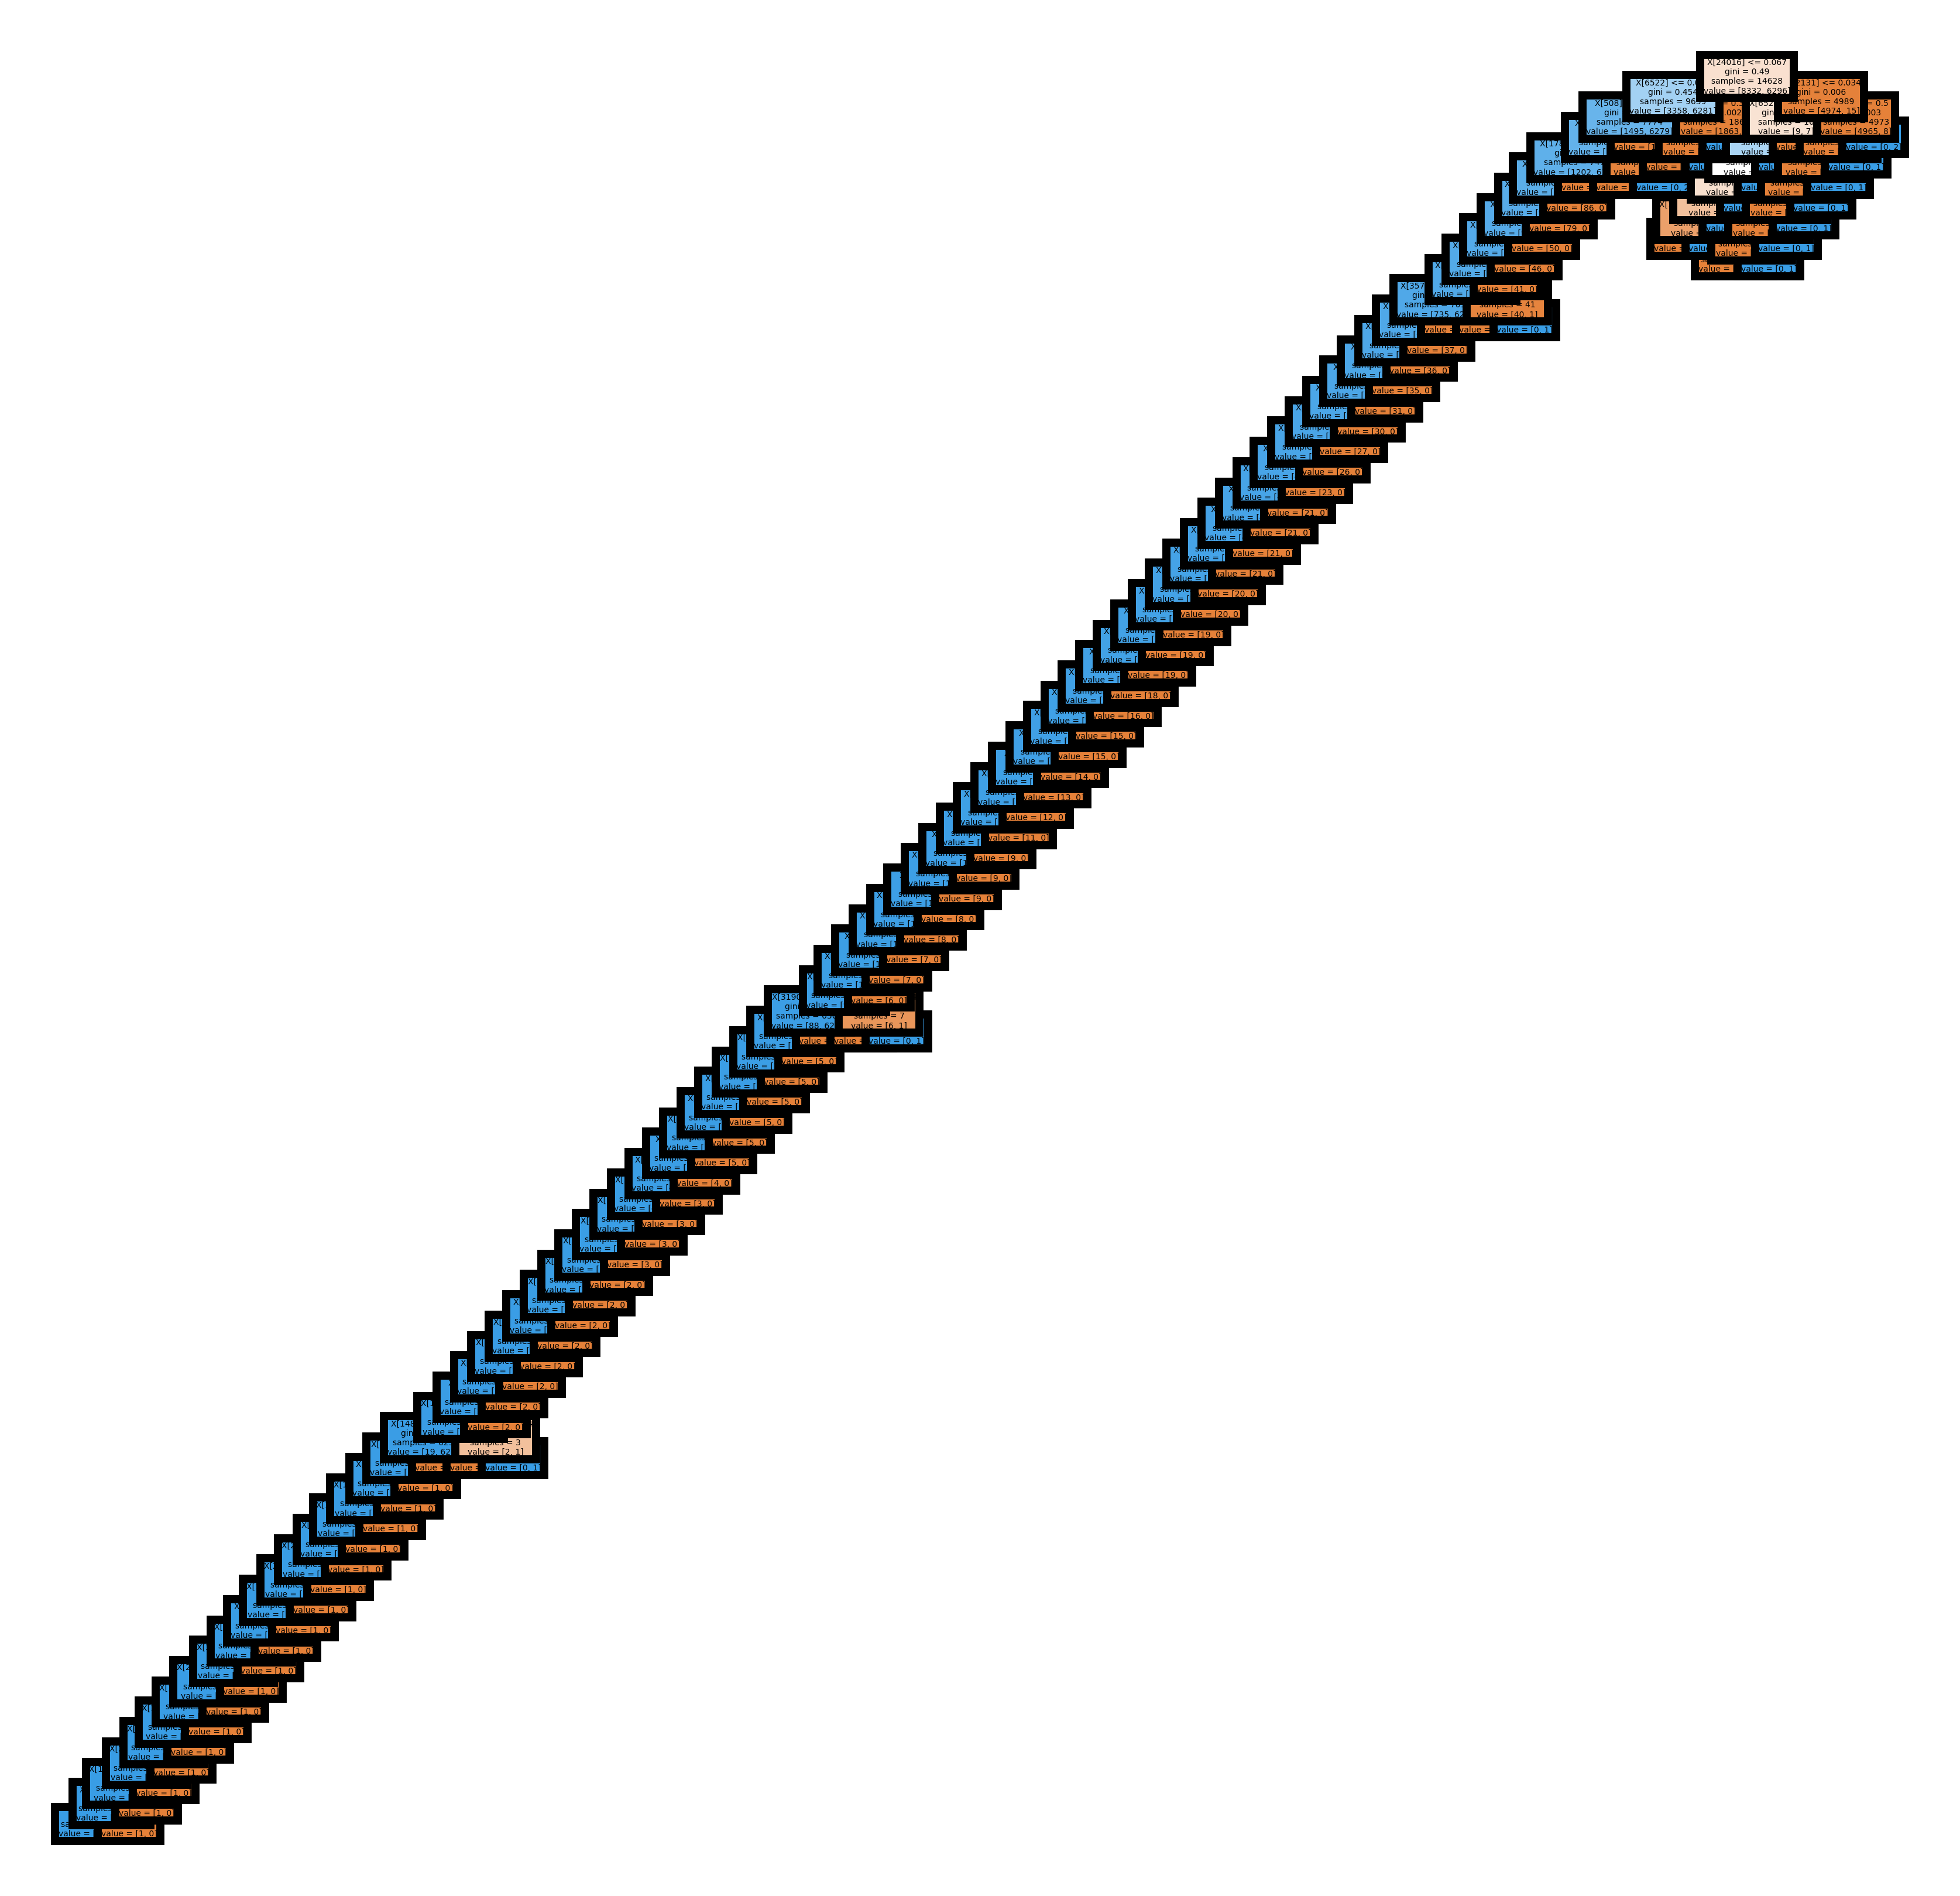

In [4]:
from sklearn.tree import plot_tree
clf = trained_models["Decision Tree"]["model"]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1000)

plot_tree(clf, filled = True);

### That didn't go too well

Αnyway, moving on..

## Using the models

Here we use the models on our test set and calculate various scores.

* Accuracy: $\frac{\textrm{Positive}}{\textrm{Total Samples}}$
* Precision: $\frac{\textrm{True Positive}}{\textrm{True Positive} + \textrm{False Positive}}$
* Recall: $\frac{\textrm{True Positive}}{\textrm{True Positive} + \textrm{False Negative}}$
* F1 score: $2 \cdot \frac{\textrm{Precision} \cdot \textrm{Recall}}{\textrm{Precision} + \textrm{Recall}}$

F1 score is also known as F1 measure.

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

results = OrderedDict()
print("Predicting...")

for name, model in trained_models.items():
    print(f"with {name}..", end = "")
    # predict
    
    tic = time()
    y_pred = model["model"].predict(x_test)
    toc = time()

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        "accuracy": acc,
        "precision": pre,
        "recall": rec,
        "f1": f1,
        "time": toc - tic
    }
    
    print(".")
    print(f"\tAccuracy score: {acc}")
    print(f"\tPrecision score: {pre}")
    print(f"\tRecall score: {rec}")
    print(f"\tF1 score: {rec}")
    print(f"\n\ttime: {toc-tic}")

Predicting...
with Decision Tree...
	Accuracy score: 0.9967186218211649
	Precision score: 0.9974603174603175
	Recall score: 0.9949335022165928
	F1 score: 0.9949335022165928

	time: 0.002557039260864258
with Multinomial Naive Bayes...
	Accuracy score: 0.9732020782061799
	Precision score: 0.9979825151311366
	Recall score: 0.9398353388220393
	F1 score: 0.9398353388220393

	time: 0.0005724430084228516
with Stochastic Gradient Descent...
	Accuracy score: 0.9972655181843041
	Precision score: 0.9974635383639823
	Recall score: 0.9962001266624446
	F1 score: 0.9962001266624446

	time: 0.00032067298889160156


## Scores

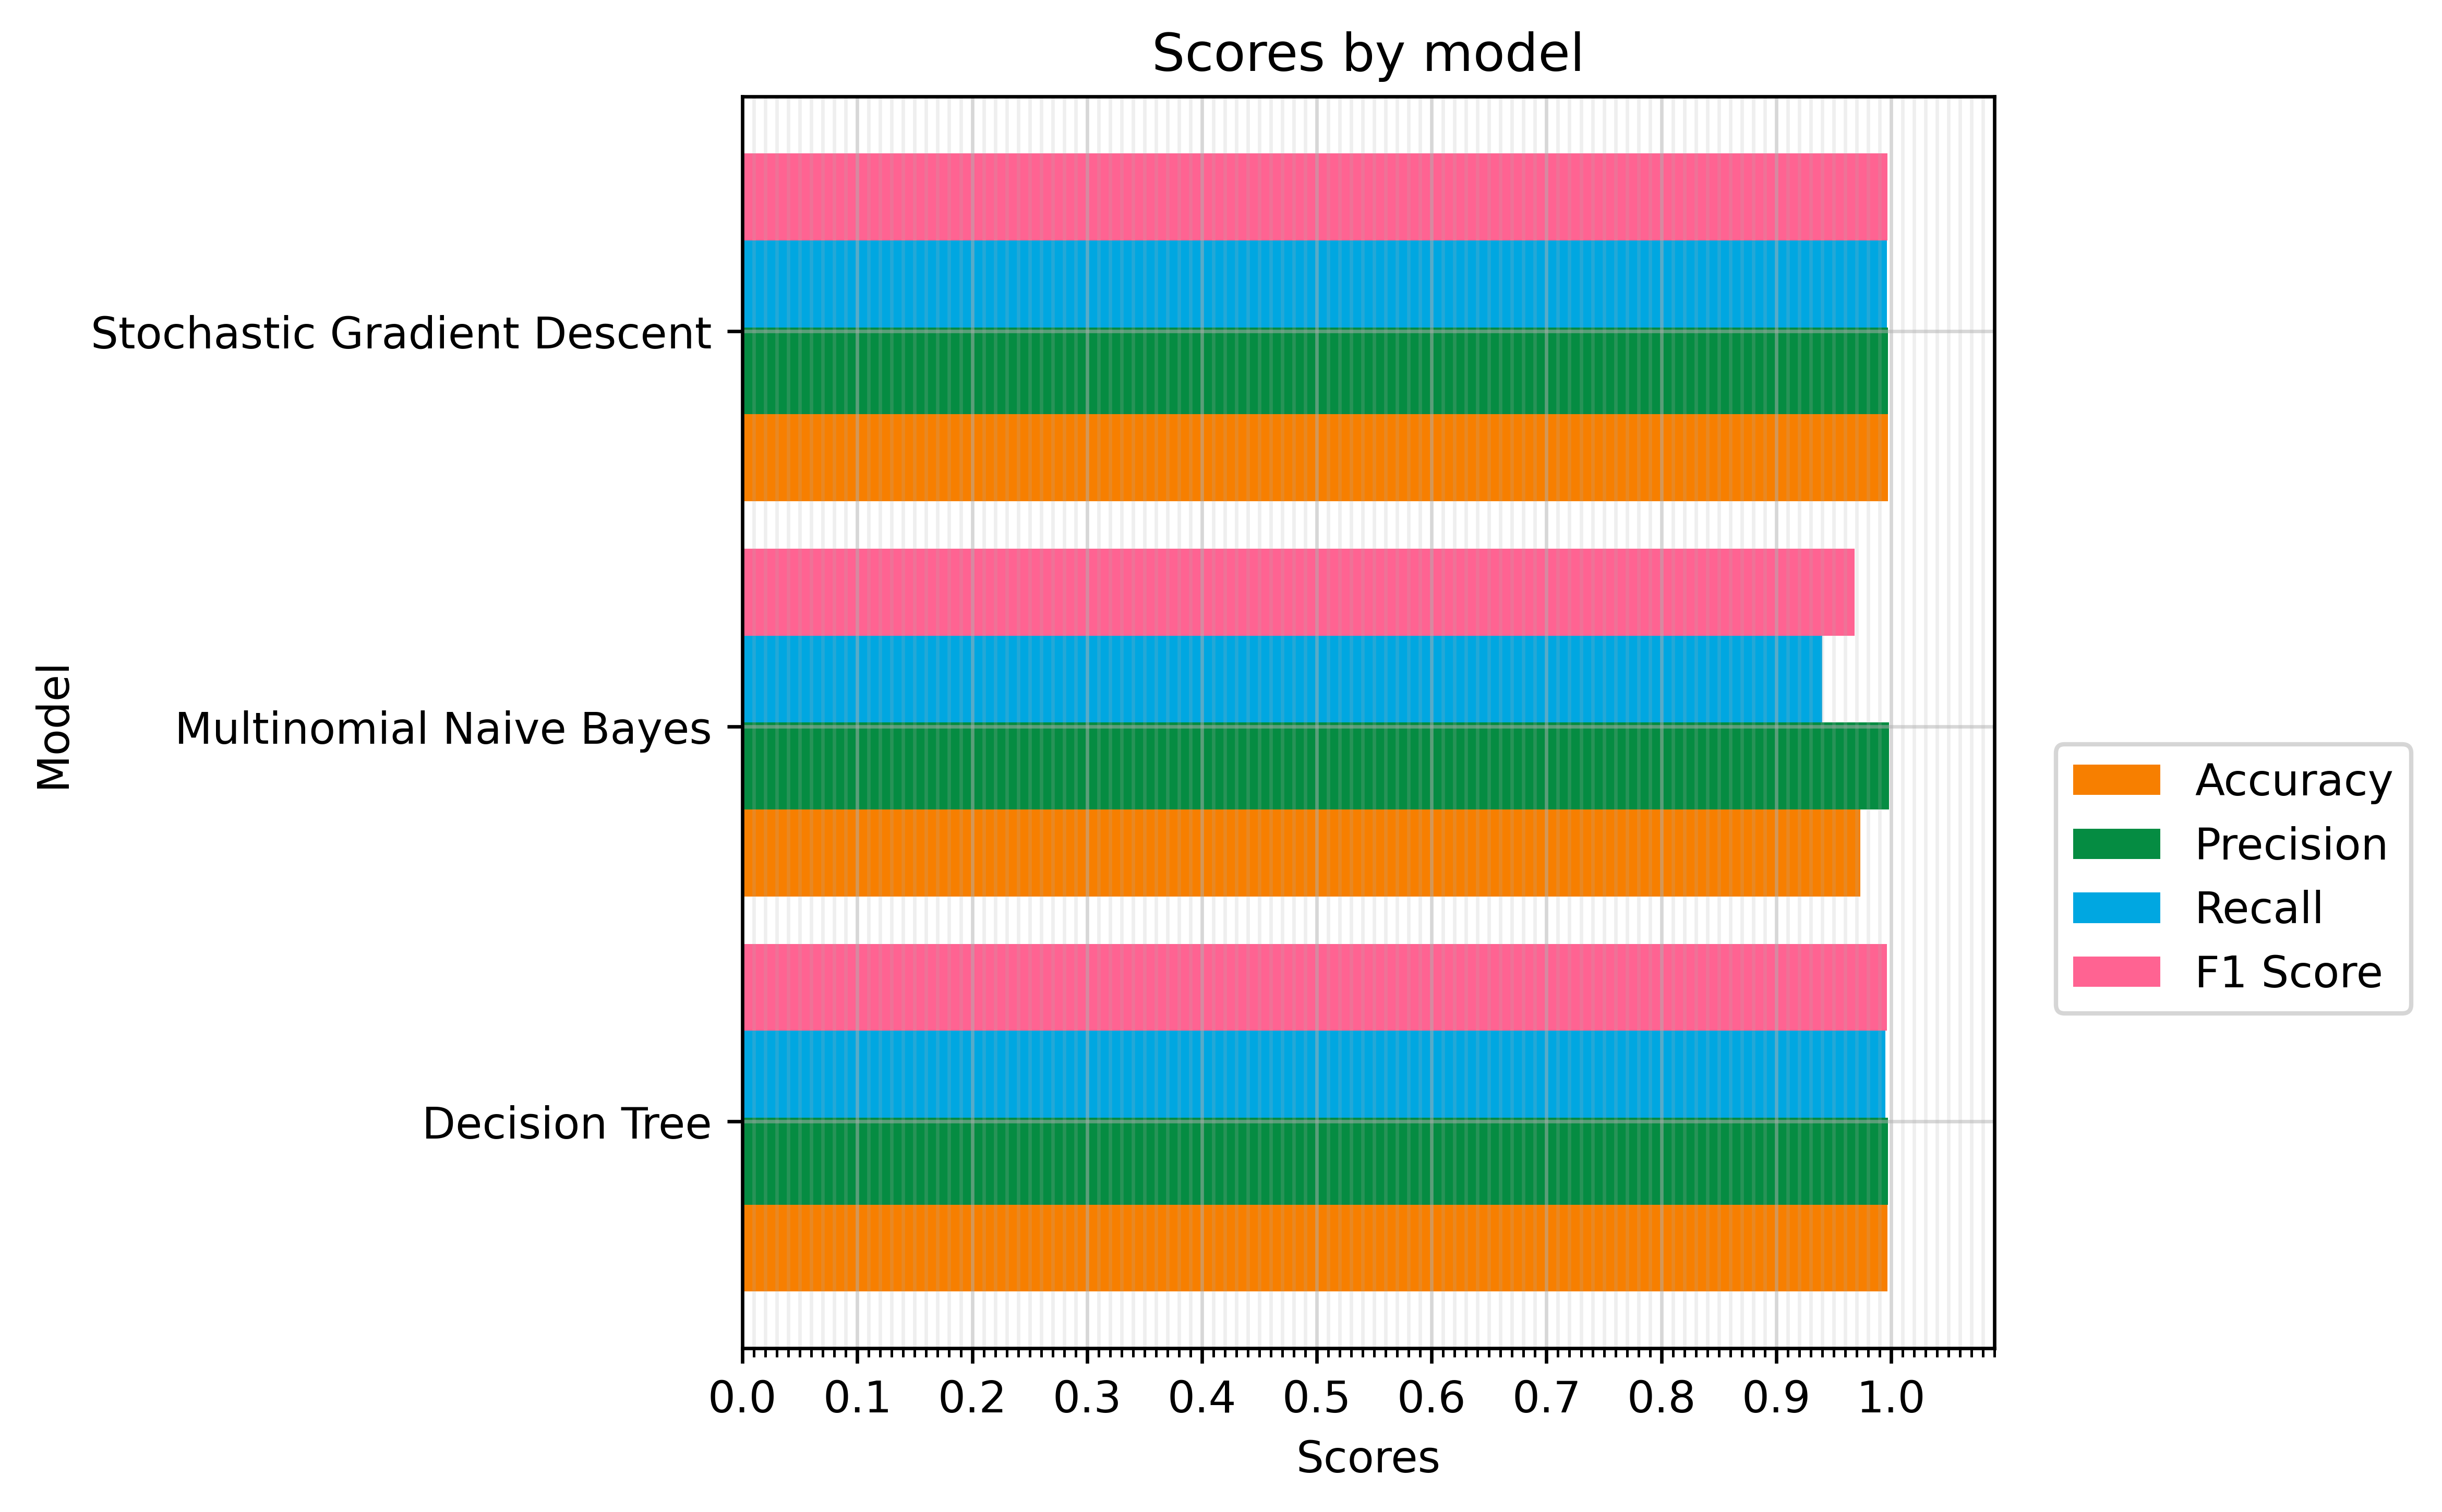

In [21]:
# create plot
fig, axes = plt.subplots(figsize = (4,4), dpi=600)


bar_width = 0.22
opacity = 0.8
ax = fig.add_axes([0,0,1,1])
index = np.arange(len(results)) + 0.1

for i, (name, scores) in enumerate(results.items()):
    
    # print(scores["accuracy"])  # sanity check
    ax.barh((i * 1) + bar_width, scores["accuracy"], color = '#F77F00', height = bar_width)
    ax.barh((i * 1) + 2 * bar_width, scores["precision"], color = '#058C42', height = bar_width)
    ax.barh((i * 1) + 3 * bar_width, scores["recall"], color = '#00A7E1', height = bar_width)
    ax.barh((i * 1) + 4 * bar_width, scores["f1"], color = '#FF6392', height = bar_width)

plt.ylabel('Model')
plt.xlabel('Scores')
plt.title('Scores by model')

plt.yticks(index + 2 * bar_width, models.keys())#, size = 7)

major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.01)

# plt.yticks(major_ticks) # FIRST
# plt.yticks(minor_ticks) # SECOND ! IMPORTANT
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor = True)

# plt.minorticks_on()
# plt.yscale("log")  # value{"linear", "log", "symlog", "logit"

plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)

plt.legend(["Accuracy", "Precision", "Recall", "F1 Score"], bbox_to_anchor=(1.35,0.5), loc = "upper right")
# plt.tight_layout()
plt.savefig('scores.png', dpi=300, bbox_inches = "tight")
plt.show()

# Training time

We use a logarithmic y-axis because the results are too similar to view with normal axis scaling.

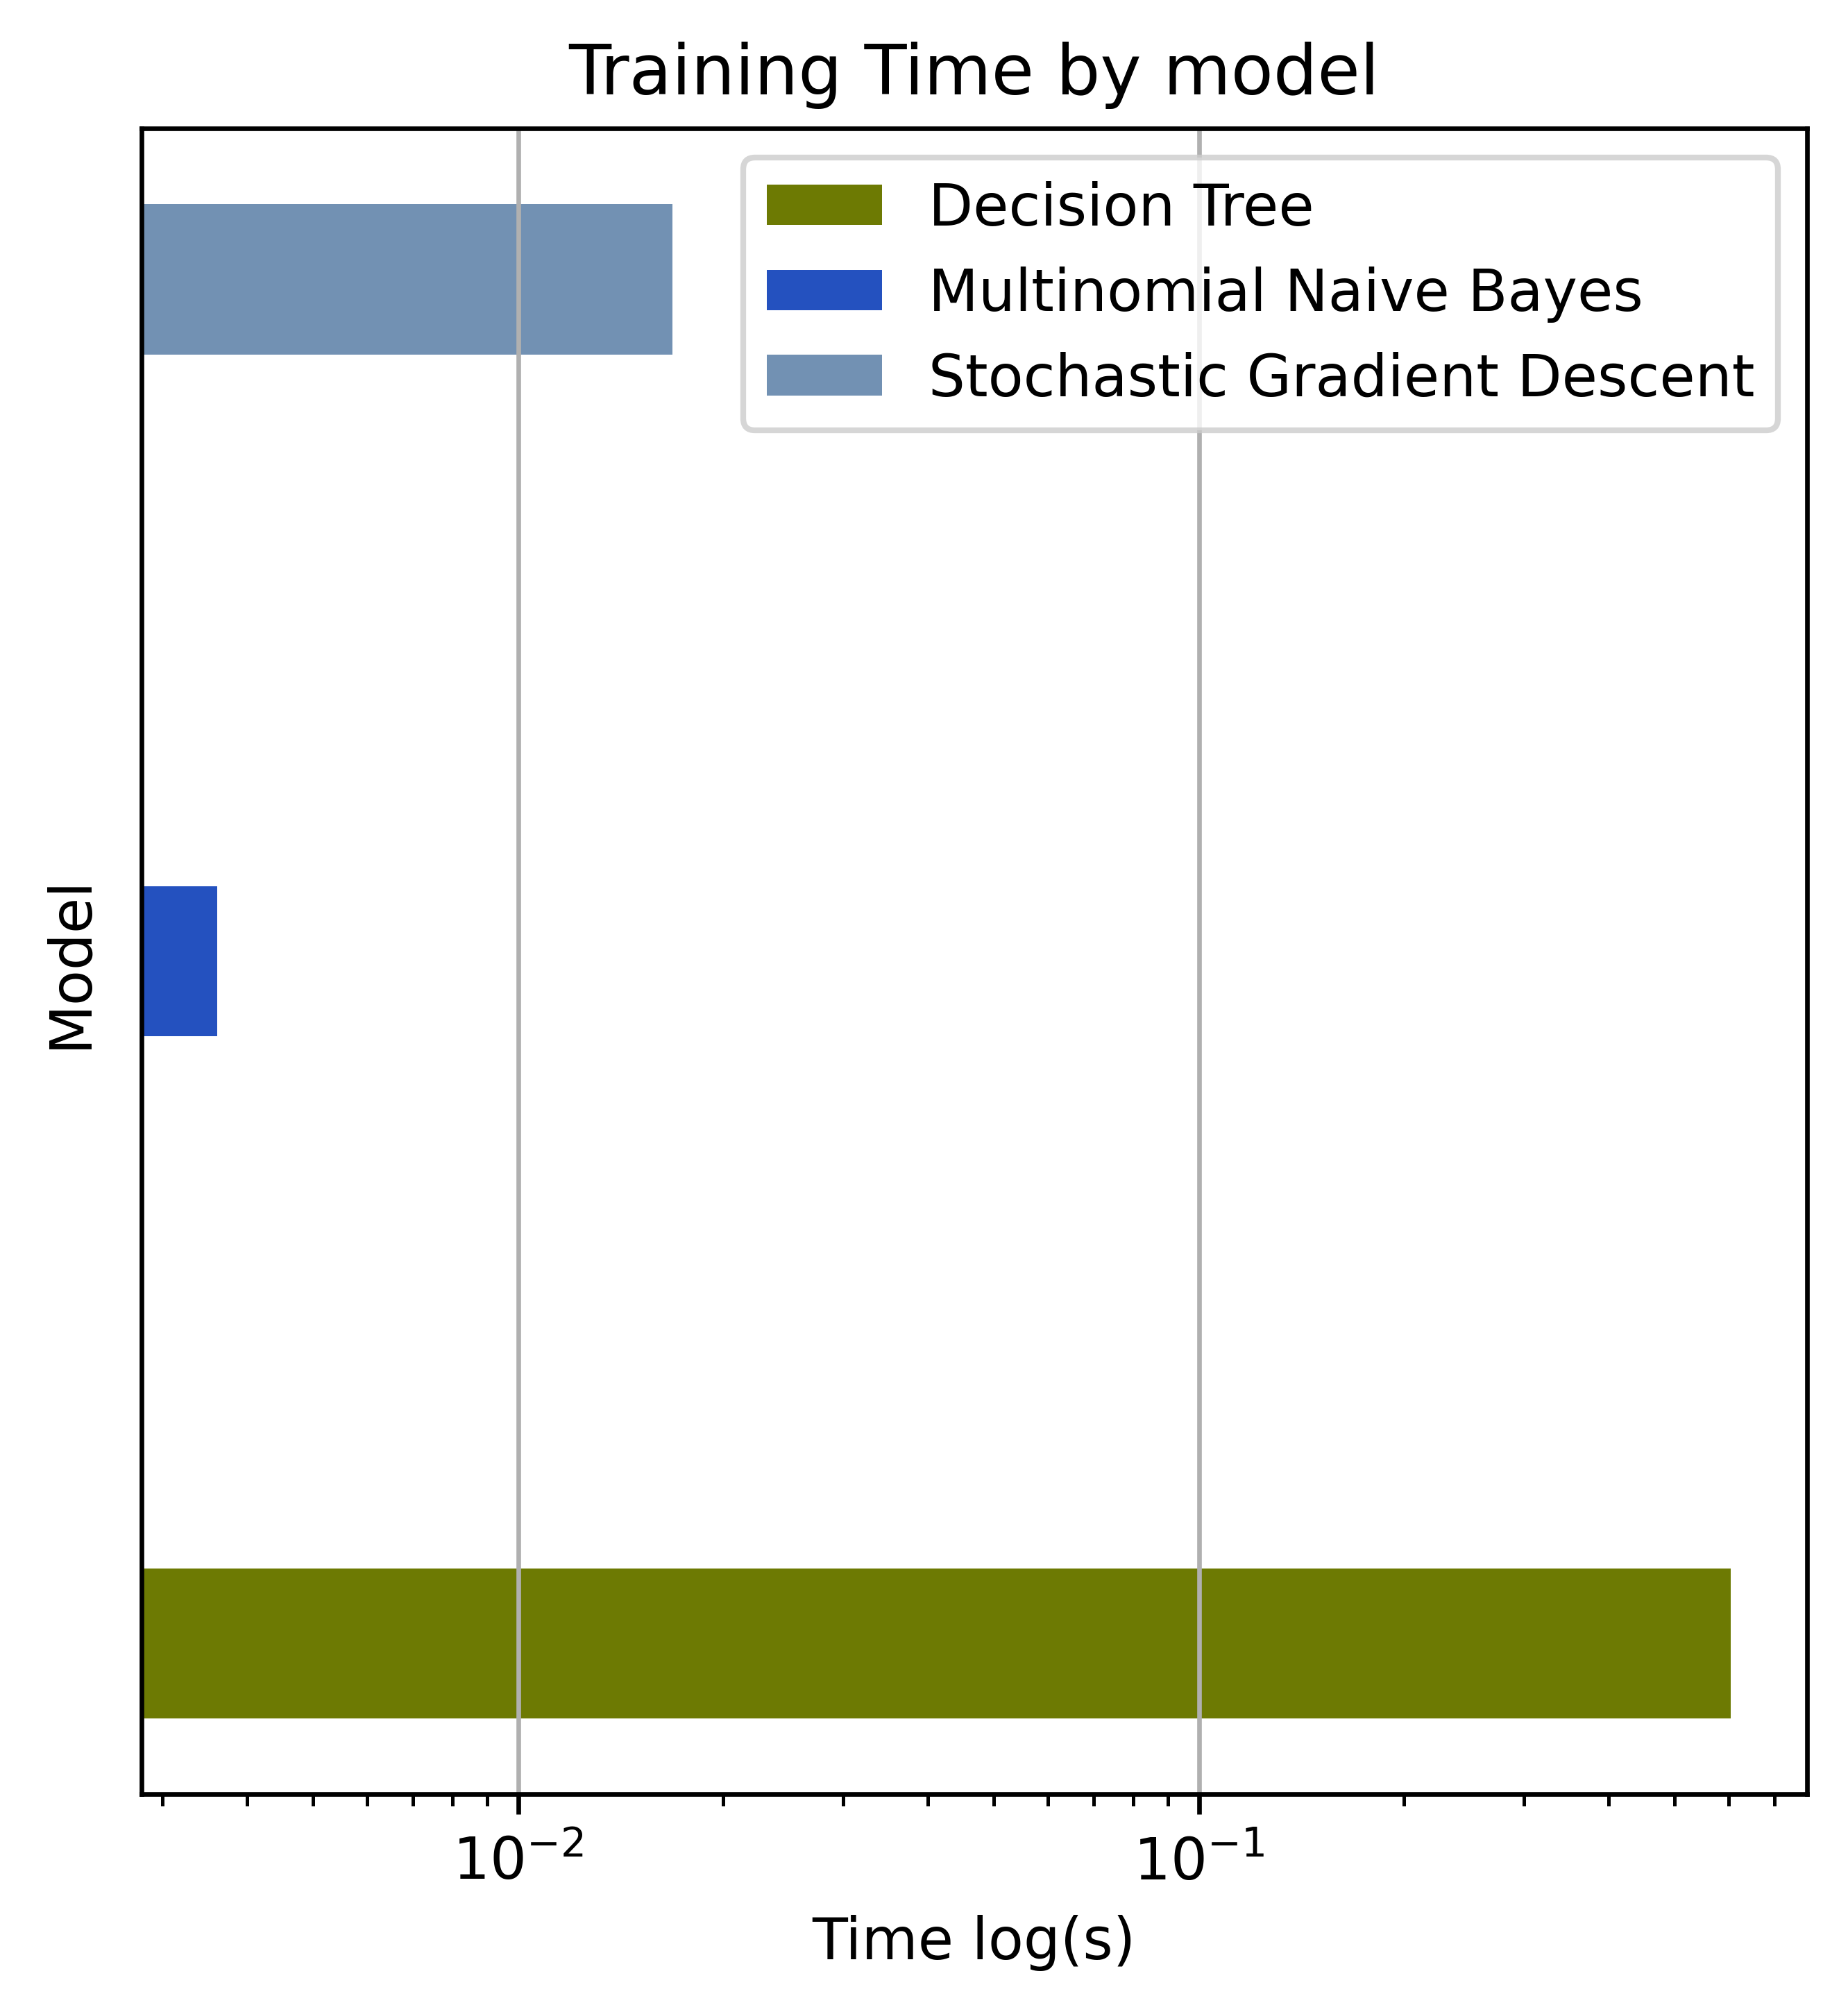

In [9]:
from random import sample

def random_color():
    return f"#{''.join(sample('0123456789ABCDEF',6))}"

# create plot
fig, axes = plt.subplots(figsize = (4,4), dpi=600)

bar_width = 0.22
opacity = 0.8
ax = fig.add_axes([0,0,1,1])
index = np.arange(len(models))

for i, (name, model) in enumerate(trained_models.items()):
        ax.barh(i + bar_width, model["time"], color = random_color(), height = bar_width, label = name)

plt.ylabel('Model')
plt.xlabel('Time log(s)')
plt.title('Training Time by model')
plt.xscale("log")  # value{"linear", "log", "symlog", "logit"

# plt.yticks(index + bar_width, models.keys())#, size = 7)
ax.set_yticks([])

plt.grid()
plt.legend()
plt.savefig('train.png', dpi=300, bbox_inches = "tight")
plt.show()

## Prediction Time

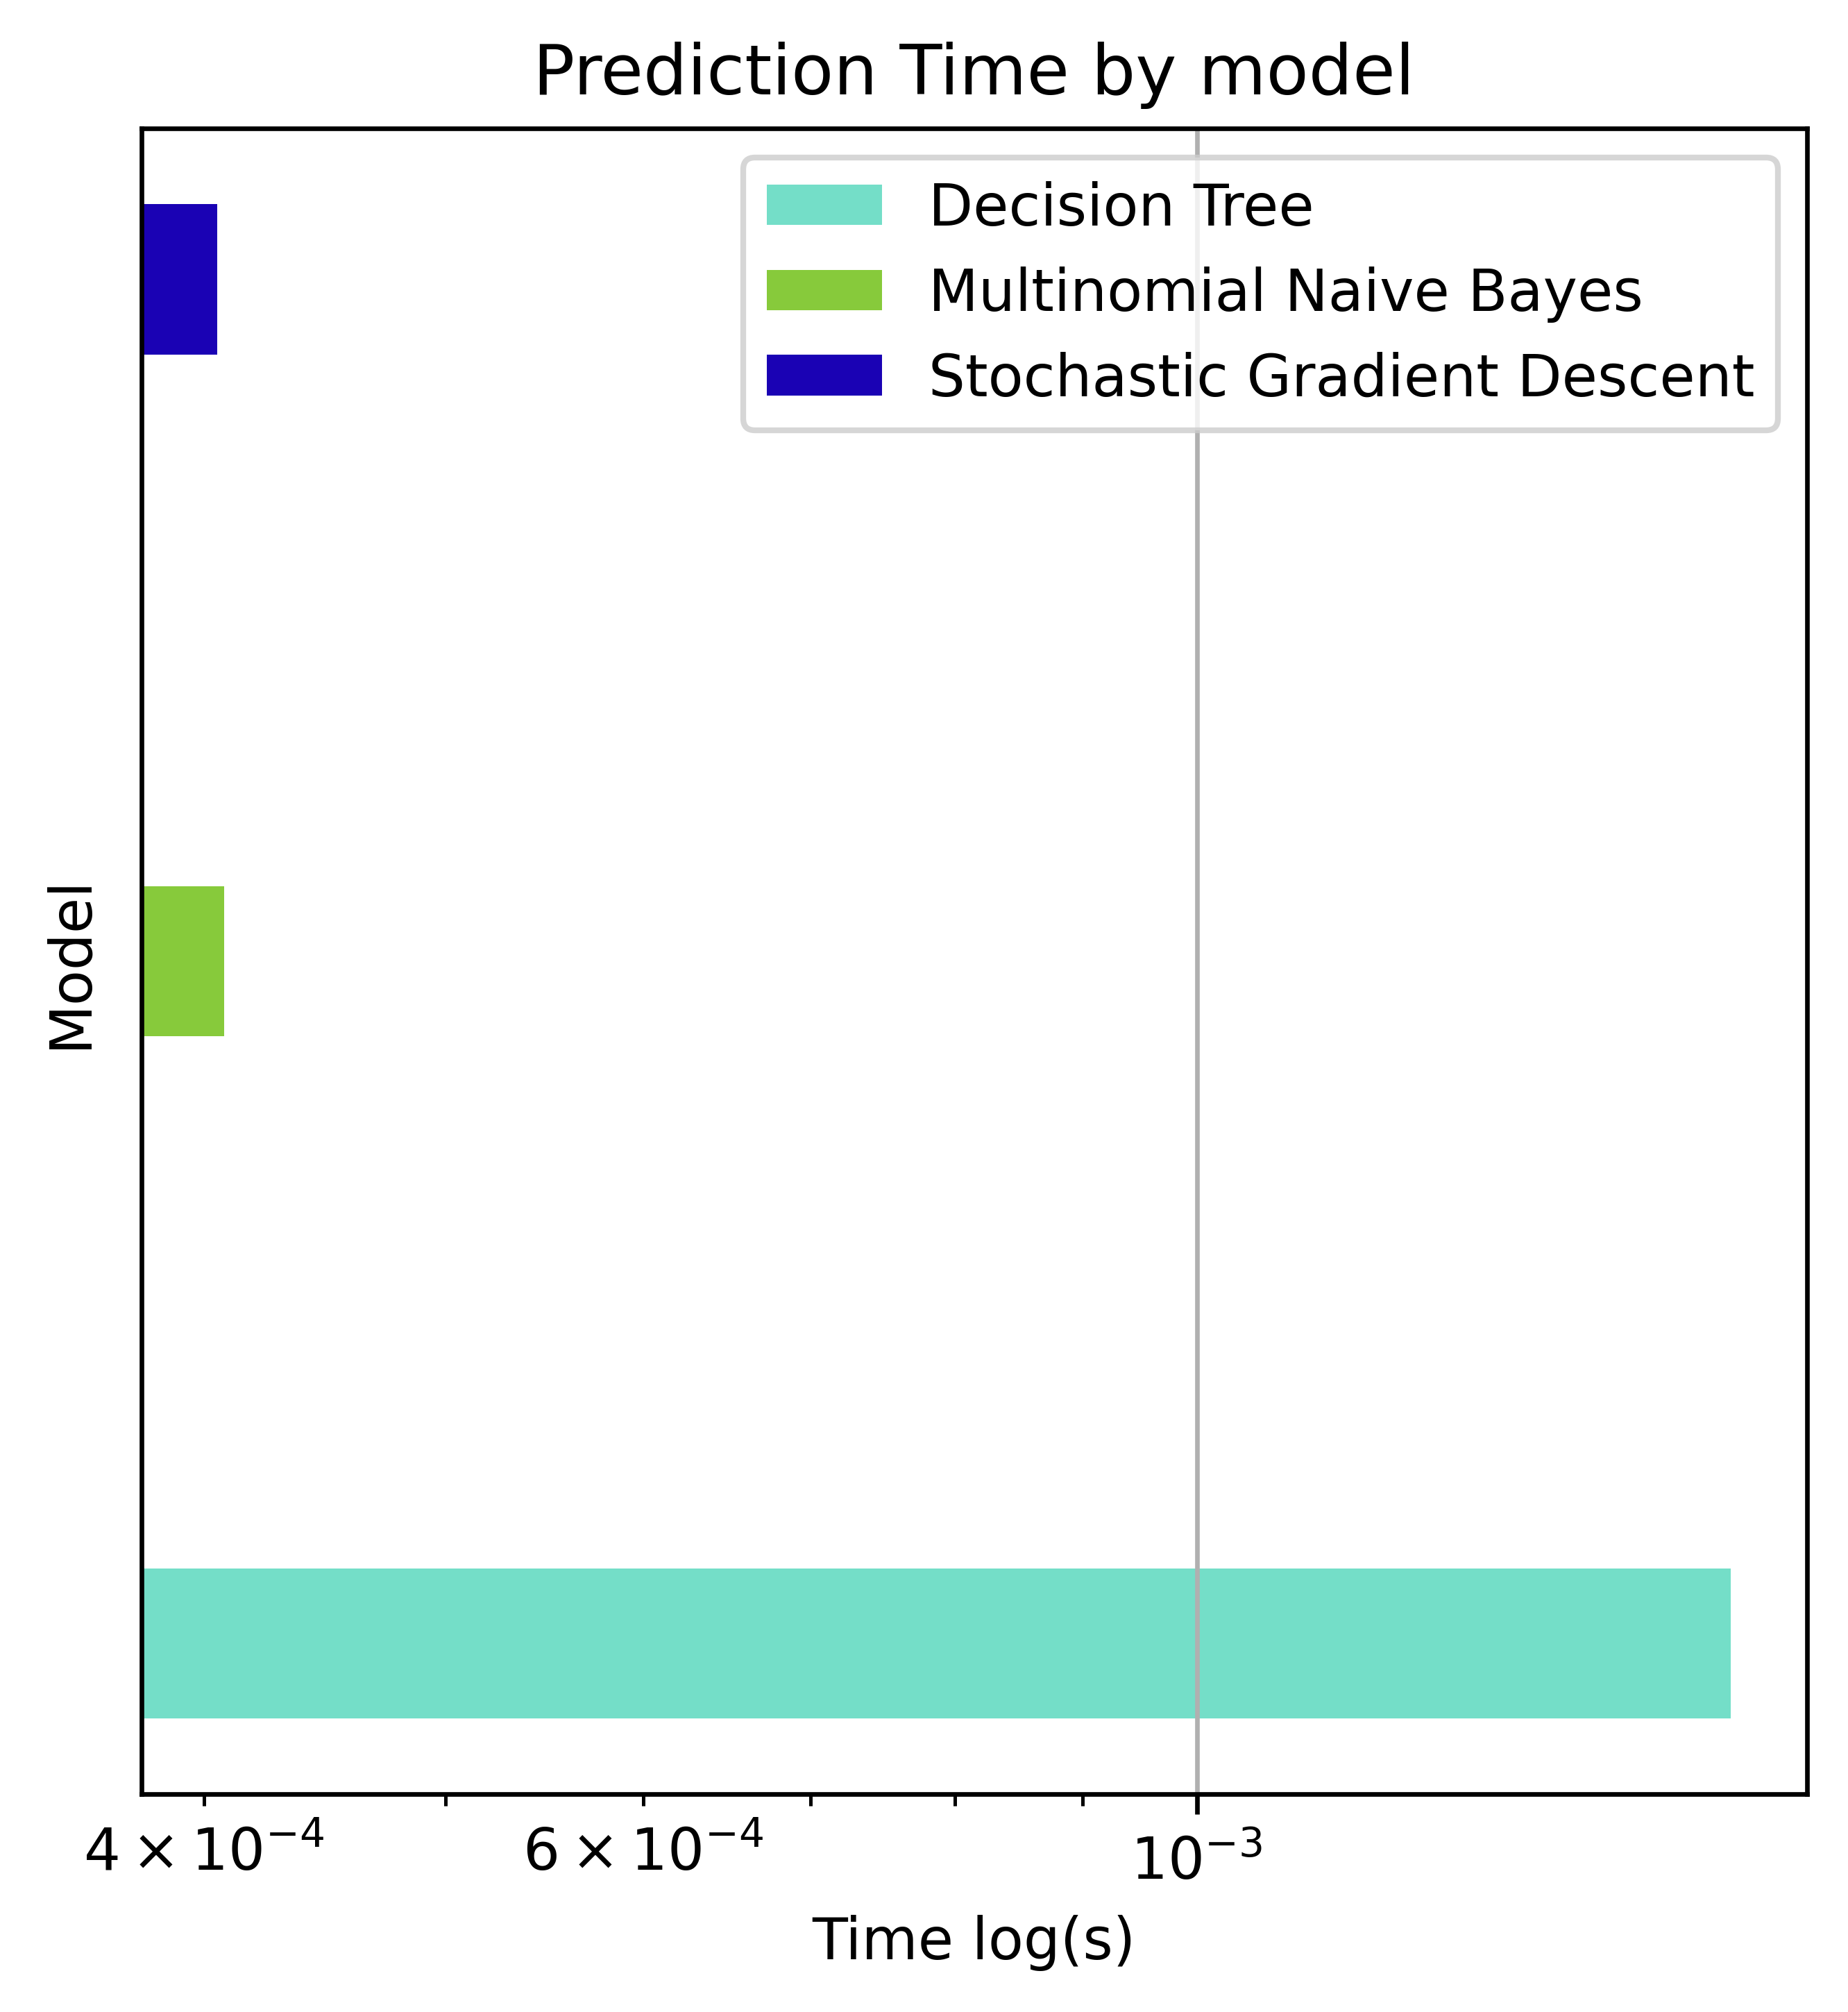

In [12]:
# create plot
fig, axes = plt.subplots(figsize = (4,4), dpi=600)

bar_width = 0.22
opacity = 0.8
ax = fig.add_axes([0,0,1,1])
index = np.arange(len(models))

for i, (name, scores) in enumerate(results.items()):
        ax.barh(i + bar_width, scores["time"], color = random_color(), height = bar_width, label = name)

plt.ylabel('Model')
plt.xlabel('Time log(s)')
plt.title('Prediction Time by model')
plt.xscale("log")  # value{"linear", "log", "symlog", "logit"

ax.set_yticks([])
# plt.yticks(index + bar_width, models.keys())#, size = 7)

plt.grid()
plt.legend()
plt.savefig('pred.png' ,dpi=300, bbox_inches = "tight")
plt.show()